# Supervised Learning Project


## Introduction

In this project, I will be examining a dataset of mushrooms available from the UCI Machine Learning Repository. This data was compiled from information found in the Audobon Society Field Guide, and donated to the UCI Machine Learning Repository in 1987. We will use classification algorithms, in this case a decision tree classifier, to see if we can create a model to determine whether or not a mushroom is edible.

## Exploratoy Data Analysis

First, we'll import any necessary libraries, as well as the data for the report.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
!pip install ucimlrepo

In [3]:
#The following code block is from UCI Machine Learning Repo
#https://archive.ics.uci.edu/dataset/73/mushroom

from ucimlrepo import fetch_ucirepo

# fetch dataset
mushroom = fetch_ucirepo(id=73)

# data (as pandas dataframes)
X = mushroom.data.features
y = mushroom.data.targets

# metadata
print(mushroom.metadata)

# variable information
print(mushroom.variables)


{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely po

In [4]:
# Examine the first few rows of the data
print(X.head())
print(y.head())
print('======================================================================\n')

# Get basic statistics for numerical features (if any)
print(X.describe())
print(y.describe())
print('======================================================================\n')

# Check for missing values
print("Missing Values:")
print(X.isnull().sum())
print(y.isnull().sum())

  cap-shape cap-surface cap-color bruises odor gill-attachment gill-spacing  \
0         x           s         n       t    p               f            c   
1         x           s         y       t    a               f            c   
2         b           s         w       t    l               f            c   
3         x           y         w       t    p               f            c   
4         x           s         g       f    n               f            w   

  gill-size gill-color stalk-shape  ... stalk-surface-below-ring  \
0         n          k           e  ...                        s   
1         b          k           e  ...                        s   
2         b          n           e  ...                        s   
3         n          n           e  ...                        s   
4         b          k           t  ...                        s   

  stalk-color-above-ring stalk-color-below-ring veil-type veil-color  \
0                      w                    

poisonous
e    4208
p    3916
Name: count, dtype: int64


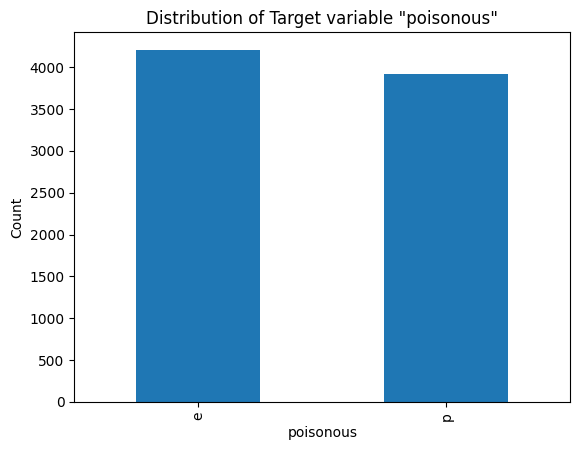

In [5]:
# Explore the distribution of the target variable
print(y['poisonous'].value_counts())
y['poisonous'].value_counts().plot(kind='bar')
plt.title('Distribution of Target variable "poisonous"')
plt.xlabel('poisonous')
plt.ylabel('Count')
plt.show()


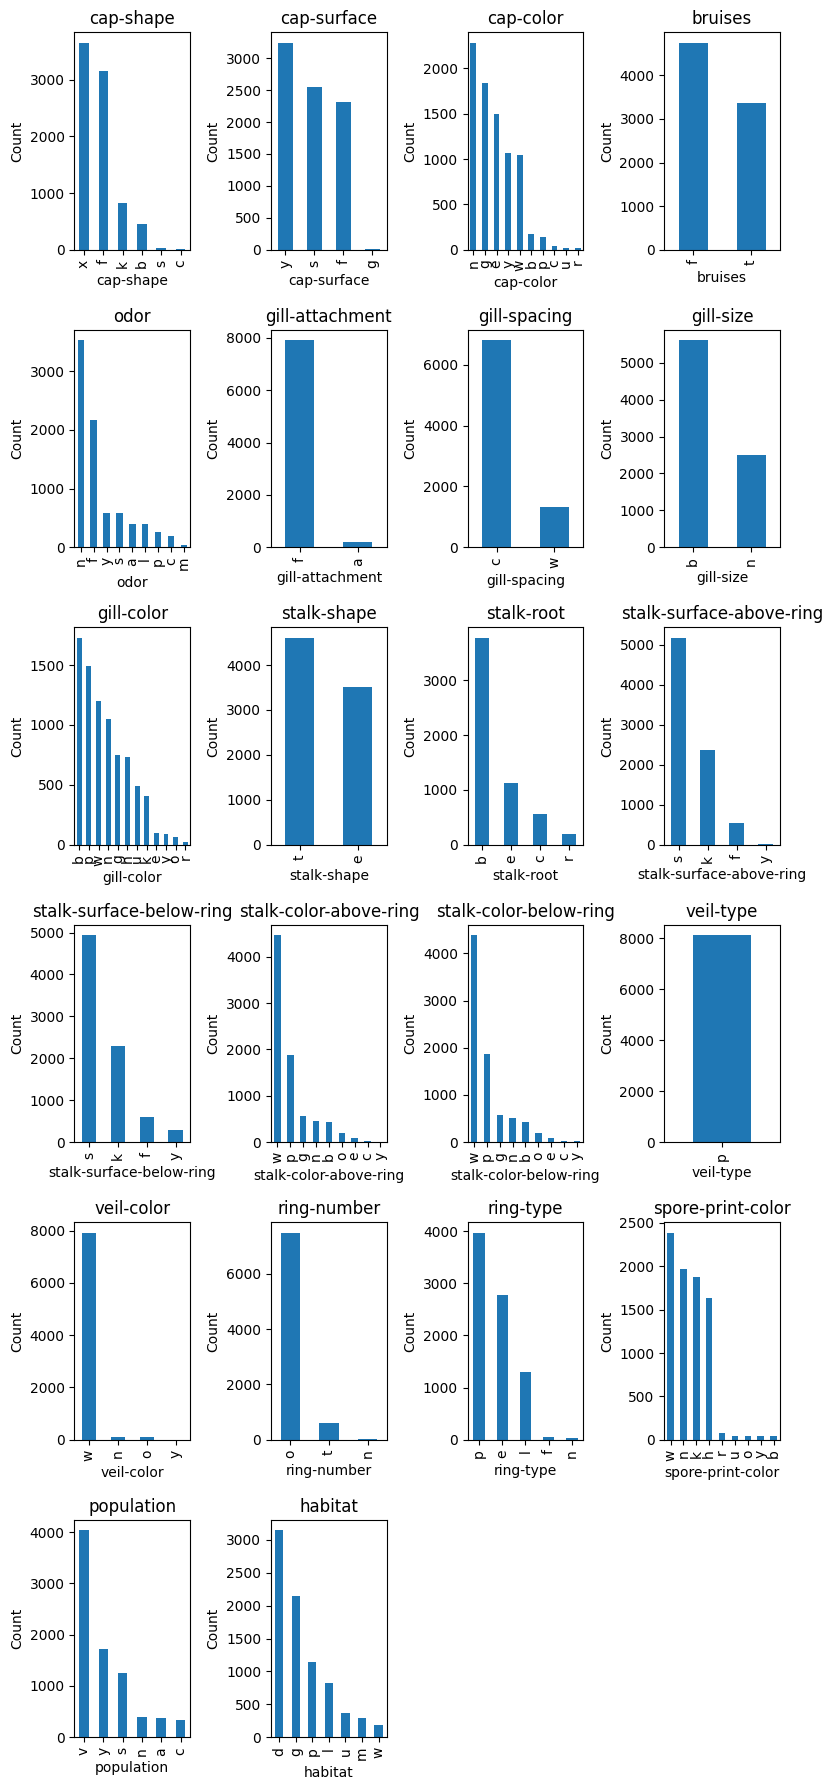

In [6]:
#create plots for each feature
n_cols = 4
n_rows = (len(X.columns) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 3 * n_rows))
axes = axes.flatten()

for i, col in enumerate(X.columns):
    #print(X[col].value_counts())
    X[col].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')


# remove unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

plt.tight_layout() # Adjusts spacing between subplots
plt.show()

Based on the above, it looks like we can definitely drop 'veil-type' as a feature. Other features like 'gill-attachemnt', 'veil-color', and 'ring-number', also look like good candidates to drop as almost all the values in these categories are the same value.

In [7]:
ubie12X = X.drop(['gill-attachment', 'veil-type', 'veil-color', 'ring-number'], axis=1)

## Model

For this data I'm chosing to use a decision tree classifier. We'll first split our data into a training set and a testing set. Before we do that however, since all of our columns are categroical, we'll need to encode it. The following usese sklearn's LabelEncoder to accomplish this.

In [11]:
label_encoders = {}

# for X
for col in X.columns:
    le_x = LabelEncoder()
    X[col] = le_x.fit_transform(X[col])  # Apply label encoding to each column
    label_encoders[col] = le_x #store the encoders
# for y
le_y = LabelEncoder()
y['poisonous'] = le_y.fit_transform(y['poisonous'])
label_encoders['poisonous'] = le_y

<ipython-input-11-5274cc296327>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le_x.fit_transform(X[col])  # Apply label encoding to each column
<ipython-input-11-5274cc296327>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le_x.fit_transform(X[col])  # Apply label encoding to each column
<ipython-input-11-5274cc296327>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [12]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define hyperparameters for tuning
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': [0.01, 0.1]
}

results = []
for max_depth in param_grid['max_depth']:
    for max_features in param_grid['max_features']:
        if max_depth is None and max_features is None:
            continue
        for ccp_alpha in param_grid['ccp_alpha']:
            dt_classifier = DecisionTreeClassifier(max_depth=max_depth,
                                                  max_features=max_features,
                                                  ccp_alpha = ccp_alpha,
                                                  random_state = 42)

            dt_classifier.fit(X_train, y_train)
            y_pred = dt_classifier.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            results.append([max_depth, max_features, ccp_alpha, accuracy, recall])


results_df = pd.DataFrame(results, columns=['Max Depth', 'Max Features', 'CCP Alpha', 'Accuracy', 'Recall'])
results_df


,Max Depth,Max Features,CCP Alpha,Accuracy,Recall
0,NaN,sqrt,0.01,0.928000,0.890026
1,NaN,sqrt,0.10,0.798154,0.714834
2,NaN,log2,0.01,0.928000,0.890026
3,NaN,log2,0.10,0.798154,0.714834
4,10.0,None,0.01,0.984000,0.980818
5,10.0,None,0.10,0.798154,0.714834
6,10.0,sqrt,0.01,0.928000,0.890026
7,10.0,sqrt,0.10,0.798154,0.714834
8,10.0,log2,0.01,0.928000,0.890026
9,10.0,log2,0.10,0.798154,0.714834


In [13]:
# Find the best model based on accuracy, recall
best_model_index = results_df['Accuracy'].idxmax()

#Check if there are multiple models with the same highest accuracy
max_accuracy = results_df['Accuracy'].max()
candidates = results_df[results_df['Accuracy'] == max_accuracy]

if len(candidates)>1:
  best_model_index = candidates['Recall'].idxmax()
  max_recall = candidates['Recall'].max()
  candidates = results_df[(results_df['Accuracy'] == max_accuracy) & (results_df['Recall'] == max_recall)]

best_model = results_df.loc[best_model_index]

print(f"Best model parameters:\n{best_model}")


Best model parameters:
Max Depth           10.0
Max Features        None
CCP Alpha           0.01
Accuracy           0.984
Recall          0.980818
Name: 4, dtype: object


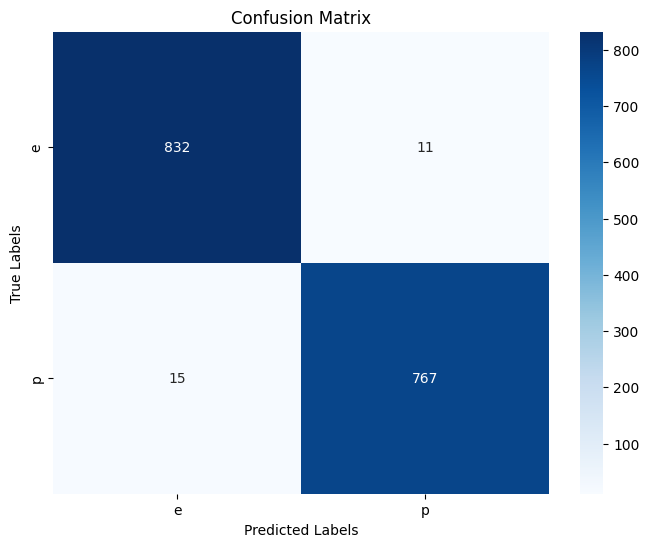

In [14]:
# confusion matrix using best model above
max_depth = 10
max_features = best_model['Max Features']
ccp_alpha = best_model['CCP Alpha']

dt_classifier = DecisionTreeClassifier(max_depth=max_depth,
                                                  max_features=max_features,
                                                  ccp_alpha = ccp_alpha,
                                                  random_state = 42)

dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)  # Use the best model to make predictions

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['e', 'p'],
            yticklabels=['e', 'p'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


The model does a pretty good job of predicting whether a mushroom is edible or not, but depending on a person's risk profile, this may not be enough, given the outcomes can be wildly different, ranging anywhere from feeling uncorfortable to death.

## Conclusion

Overall, I would say we were successful in predicting whether a mushroom is edible or not (Accuracy: 0.984, and Precision: .980818). However, given that a bad mushroom can have devastating consequenses, I'm not sure this would be accurate enough to rely solely on this. Subject matter expertise would be recommended. Future iterations of this project would include implementing GridSearchCV, rather than explictly looping through the parameters, and exploration of the other hyperparameters of sklearn's decision tree classifer. Other area to look into are other methods of encoding for the categorical features.

## References


*   https://archive.ics.uci.edu/dataset/73/mushroom
*   https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
*   Week 4 Lab

